# Kaggle Code

### Imports

In [ ]:
# Importing necessary libraries

import torch  # Core PyTorch library for tensor operations
from torchvision import datasets, transforms  # Datasets and transformations for computer vision
import torch.nn as nn  # Neural network components
import torch.optim as optim  # Optimization algorithms
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
from torch.utils.data import DataLoader, Dataset, random_split, Subset  # Data handling utilities
import torch.nn.functional as F

### Selecting Device

In [ ]:
# Set up device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Hyper Parameters used in Training

In [54]:
batch_size = 64           # Batch size for data loading
learning_rate = 0.05      # Learning rate for optimizer
num_epochs = 100           # Number of training epochs

### Data Augmentation and Loading


In [55]:
# Define transformations for training and test datasets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Augmentation: Randomly flip the image horizontally
    transforms.RandomCrop(32, padding=4),  # Augmentation: Random cropping with padding
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                         std=(0.2675, 0.2565, 0.2761)),  # Normalize to CIFAR-100 statistics
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                         std=(0.2675, 0.2565, 0.2761)),  # Same normalization as training
])
def get_dataloader(dataset, batch_size, shuffle):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Download the CIFAR-100 training and test dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = get_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = get_dataloader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### CNN Model

In [56]:
import torch.nn as nn
import torch.nn.functional as F

class CIFARClassifier(nn.Module):
    def __init__(self, num_classes=100):
        super(CIFARClassifier, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3x32x32, Output: 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 32x32x32, Output: 64x32x32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by a factor of 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Input: 64x16x16, Output: 128x16x16
        self.fc1 = nn.Linear(128 * 16 * 16 // 4, 256)  # Fully connected layer, with flattened input
        self.fc2 = nn.Linear(256, num_classes)  # Fully connected layer for classification

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolutions and pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # Output size: 64x16x16
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # Output size: 128x8x8

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Apply fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Loss Creterion and Optimizer

In [57]:
# Initialize model and move to device
model = CIFARClassifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropy includes softmax
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### Evaluation of Loss and Accuracy

In [58]:
# Define function to evaluate model performance
def evaluate(model, data_loader, criterion):

    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    loss_batches = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            batch_loss = criterion(outputs, labels)
            loss_batches.append(batch_loss.item())

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = np.mean(loss_batches)
    accuracy = 100 * correct / total
    model.train()  # Reset to training mode

    return accuracy, avg_loss

### Training CNN

In [59]:
# Training the model
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Clear the gradients

        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss

        loss.backward() # Backward pass
        optimizer.step() # Update weights

    # Evaluate on train and test sets after each epoch

    train_accuracy, train_loss = evaluate(model, trainloader, criterion)
    test_accuracy, test_loss = evaluate(model, testloader, criterion)


    print(f'Epoch {epoch+1:02d}/{num_epochs:02d} - Train Loss: {train_loss:.6f}, Train Acc: {train_accuracy:.2f}%')
    print(f'            - Test Loss: {test_loss:.6f}, Test Acc: {test_accuracy:.2f}%')
    print("-" * 60)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Epoch 01/100 - Train Loss: 4.003994, Train Acc: 6.97%
            - Test Loss: 3.998636, Test Acc: 7.49%
------------------------------------------------------------
Epoch 02/100 - Train Loss: 3.856690, Train Acc: 11.21%
            - Test Loss: 3.817890, Test Acc: 12.43%
------------------------------------------------------------
Epoch 03/100 - Train Loss: 3.644243, Train Acc: 13.49%
            - Test Loss: 3.584508, Test Acc: 15.06%
------------------------------------------------------------
Epoch 04/100 - Train Loss: 3.355134, Train Acc: 19.06%
            - Test Loss: 3.286676, Test Acc: 19.96%
------------------------------------------------------------
Epoch 05/100 - Train Loss: 3.132767, Train Acc: 22.81%
            - Test Loss: 3.052359, Test Acc: 24.32%
------------------------------------------------------------
Epoch 06/100 - Train Loss: 2.869557, Train Acc: 27.80%
            - Test Loss: 2.776330, Test Acc: 29.75%
-------------------------------------------------------

### Loading the test.csv file

Total samples in CSV: 10000


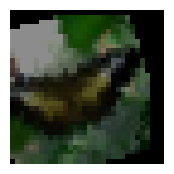

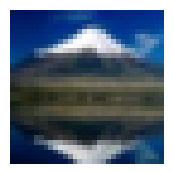

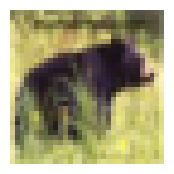

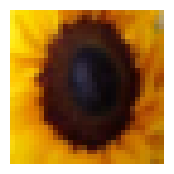

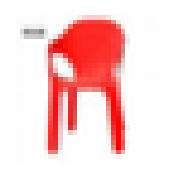

In [74]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

csv_path = 'test/test.csv'
df = pd.read_csv(csv_path)

print(f"Total samples in CSV: {len(df)}")

# Function to reverse the normalization
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Select a few samples to display (e.g., first 5)
num_samples = 5
samples = df.sample(n=num_samples)  # Randomly select samples for diversity

# Iterate through the selected samples and display images
for index, row in samples.iterrows():
    # Extract pixel data and convert to numpy array
    pixel_data = row[[f'pixel_{i}' for i in range(1, 3073)]].values.astype(np.float32)

    # Reshape to (3, 32, 32)
    image = pixel_data.reshape(3, 32, 32)

    # Convert to torch tensor
    image_tensor = torch.tensor(image)

    # Reverse the normalization
    image_tensor = unnormalize(image_tensor, cifar100_mean, cifar100_std)

    # Clip the values to [0, 1] range
    image_tensor = torch.clamp(image_tensor, 0, 1)

    # Convert to numpy array and transpose to (32, 32, 3) for plotting
    image_np = image_tensor.numpy().transpose(1, 2, 0)

    # Convert to PIL Image for better handling (optional)
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

    # Display the image using matplotlib
    plt.figure(figsize=(2,2))
    plt.imshow(image_pil)
    plt.axis('off')

### Using Model to generate submission.csv

In [75]:
model.eval()
ids = []
predicted_labels =[]
for index, row in df.iterrows():
    # Extract pixel data and convert to numpy array
    pixel_data = row[[f'pixel_{i}' for i in range(1, 3073)]].values.astype(np.float32)

    # Reshape to (3, 32, 32)
    image = pixel_data.reshape(3, 32, 32)

    # Convert to torch tensor
    image_tensor = torch.tensor(image).unsqueeze(0)

    image_tensor = image_tensor.to(device)

    img_id = int(row['ID'])
    ids.append(img_id)
    
    with torch.no_grad():
        output = model(image_tensor)
    predicted_label = torch.argmax(output, dim=1).item()
    predicted_labels.append(predicted_label)

submission = pd.DataFrame({
    'ID' : ids,
    'LABEL': predicted_labels
})

submission.to_csv('submission.csv', index=False)

### Plotting Results

In [71]:
def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = np.arange(len(train_metrics))

    plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Train and Test Loss

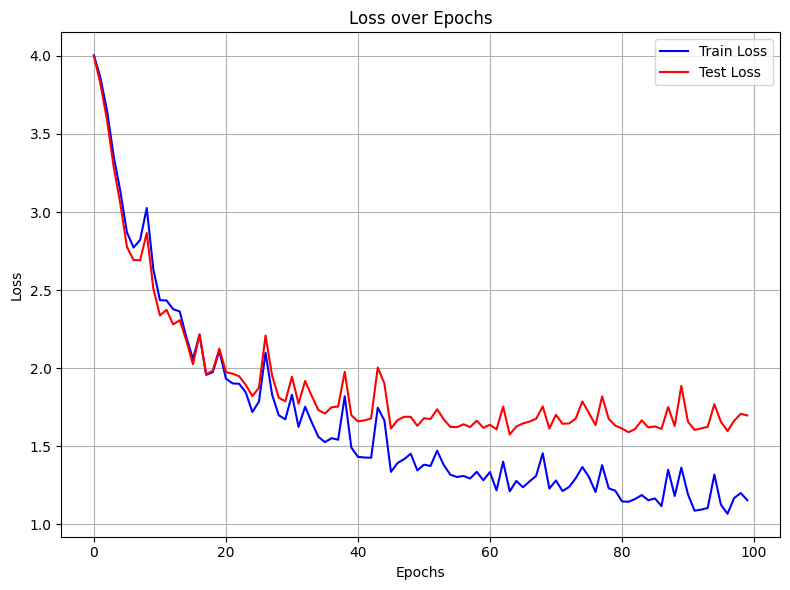

In [76]:
# Plot loss
plot_metrics(train_losses, test_losses, 'Loss')

### Train and Test Accuracy

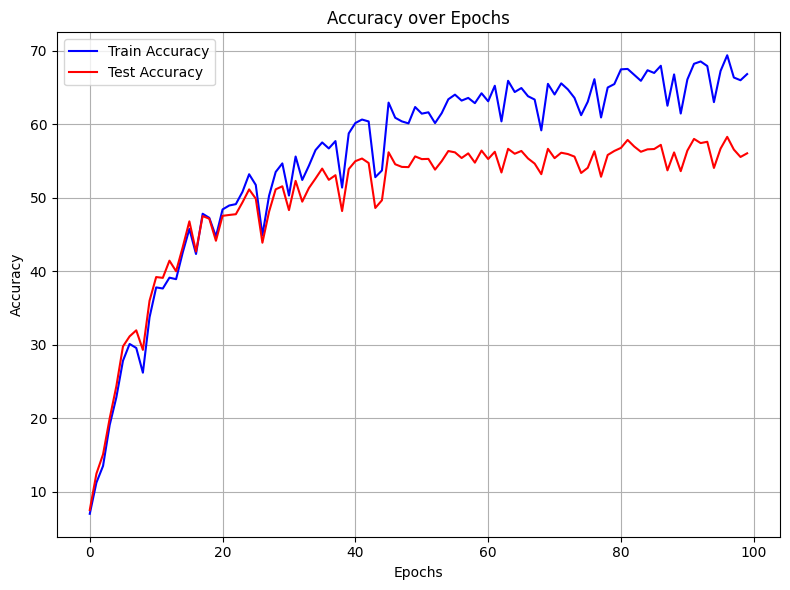

In [77]:
# Plot accuracy
plot_metrics(train_accuracies, test_accuracies, 'Accuracy')